# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [3]:
SERIES_PERIOD = 'max'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

EPOCHS = 20
BATCH_SIZE = 32

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'close': (close - close.min()) / close.max(),
    'returns': log_returns / log_returns.max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
1950-01-10,0.003545,0.000077,0.000077,0.000129,0.000077,-0.026755,0.041578
1950-01-11,0.003557,0.000089,0.000090,0.000170,0.000090,0.032097,0.026233
1950-01-12,0.003488,0.000021,0.000021,0.000200,0.000021,-0.177951,0.085538
1950-01-13,0.003470,0.000002,0.000002,0.000231,0.000002,-0.049140,0.082654
1950-01-16,0.003480,0.000012,0.000013,0.000068,0.000013,0.027332,0.077147
...,...,...,...,...,...,...,...
2022-06-03,0.861185,0.856264,0.853970,0.271154,0.853086,-0.150425,0.152406
2022-06-06,0.860591,0.861682,0.856169,0.336181,0.855774,0.028588,0.111568
2022-06-07,0.852630,0.860869,0.850104,0.303397,0.863957,0.086503,0.116048


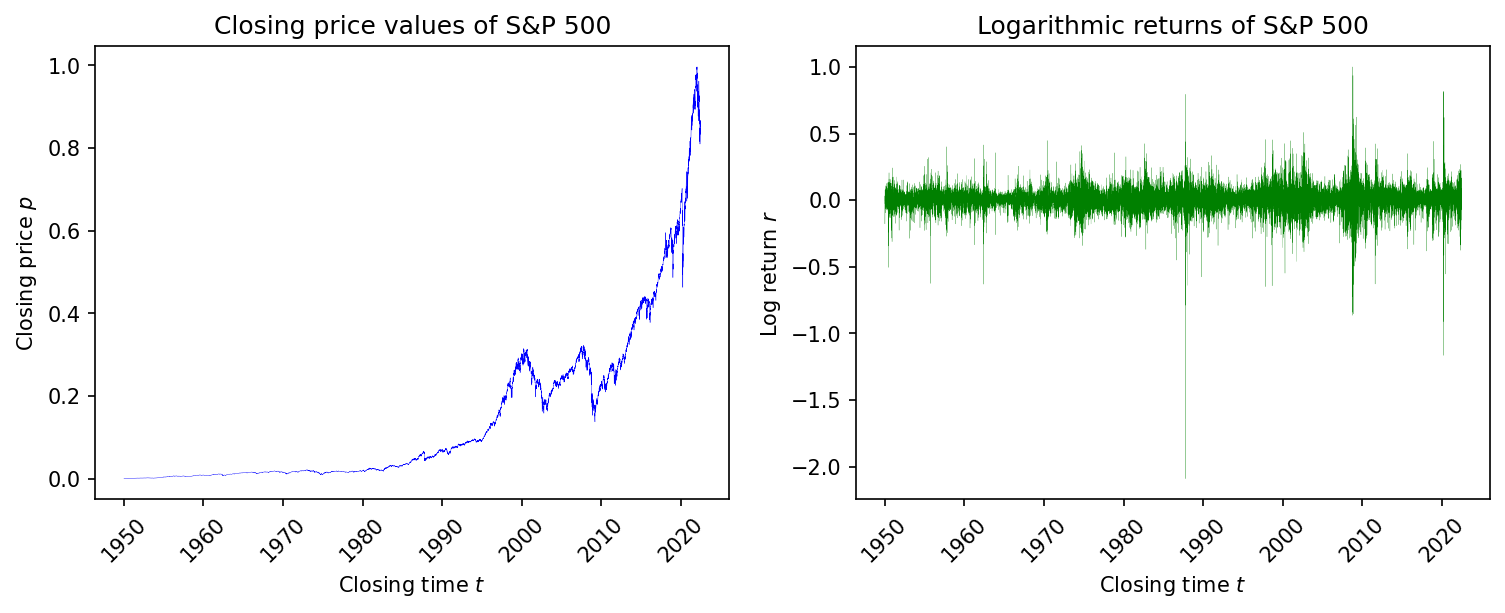

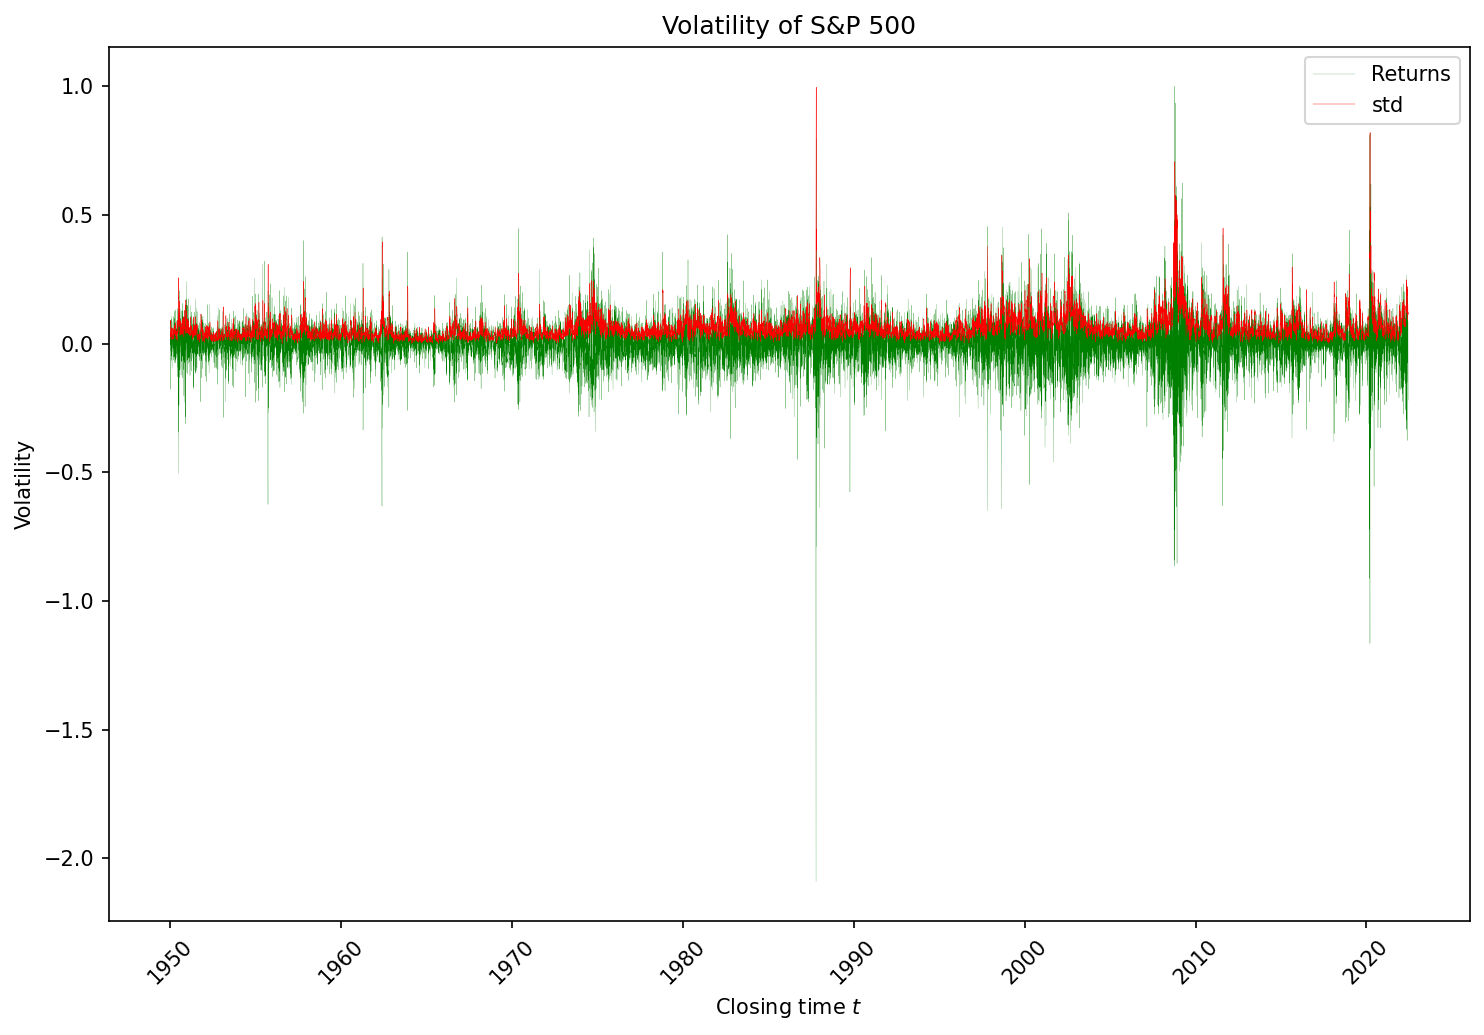

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.1, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.2, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)
X_training = X_data[:split]
y_training = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=(1 - TRAIN_VAL_SPLIT), shuffle=True)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

90% training data, 10% testing data
(14751, 10, 7) (14751, 1) 
 (1822, 10, 7) (1822, 1)


In [7]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

# models = {
#     'RNN': rnn_model, 
#     'GRU': gru_model, 
#     'LSTM': lstm_model, 
#     'BIDIR': bidir_model
# }

models = {
    'RNN': rnn_model,
    'LSTM': lstm_model
}

for model in models.values():
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [8]:
histories = {}
for m in range(len(models)):
    model = list(models.values())[m]
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))
    histories.update({list(models.keys())[m]: history.history})

Epoch 1/20
461/461 [==============================] - 11s 20ms/step - loss: 0.0278 - mse: 0.0115 - val_loss: 0.0160 - val_mse: 5.4968e-04
Epoch 2/20
461/461 [==============================] - 9s 19ms/step - loss: 0.0140 - mse: 5.1355e-04 - val_loss: 0.0133 - val_mse: 3.9894e-04
Epoch 3/20
461/461 [==============================] - 9s 21ms/step - loss: 0.0141 - mse: 5.1540e-04 - val_loss: 0.0121 - val_mse: 3.6276e-04
Epoch 4/20
461/461 [==============================] - 9s 20ms/step - loss: 0.0135 - mse: 4.8207e-04 - val_loss: 0.0133 - val_mse: 4.3350e-04
Epoch 5/20
461/461 [==============================] - 9s 19ms/step - loss: 0.0132 - mse: 4.8106e-04 - val_loss: 0.0139 - val_mse: 4.7223e-04
Epoch 6/20
461/461 [==============================] - 9s 19ms/step - loss: 0.0131 - mse: 4.7658e-04 - val_loss: 0.0127 - val_mse: 3.6933e-04
Epoch 7/20
461/461 [==============================] - 9s 19ms/step - loss: 0.0130 - mse: 4.7236e-04 - val_loss: 0.0137 - val_mse: 4.2105e-04
Epoch 8/20
461/4

In [9]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    prediction = model.predict(X_test)
    
    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(prediction + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    metrics.update({
        list(models.keys())[m]: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({    
        list(models.keys())[m]: prediction * volatility.max() + volatility.min()
    })

    print(f" - {list(models.keys())[m]}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")


x = 2
y = len(metrics) // x

 - RNN: 
	 mae = 0.01317; mse = 0.00056; msle = 0.00039; mape = 23.67735%
 - LSTM: 
	 mae = 0.01123; mse = 0.00035; msle = 0.00026; mape = 22.97771%


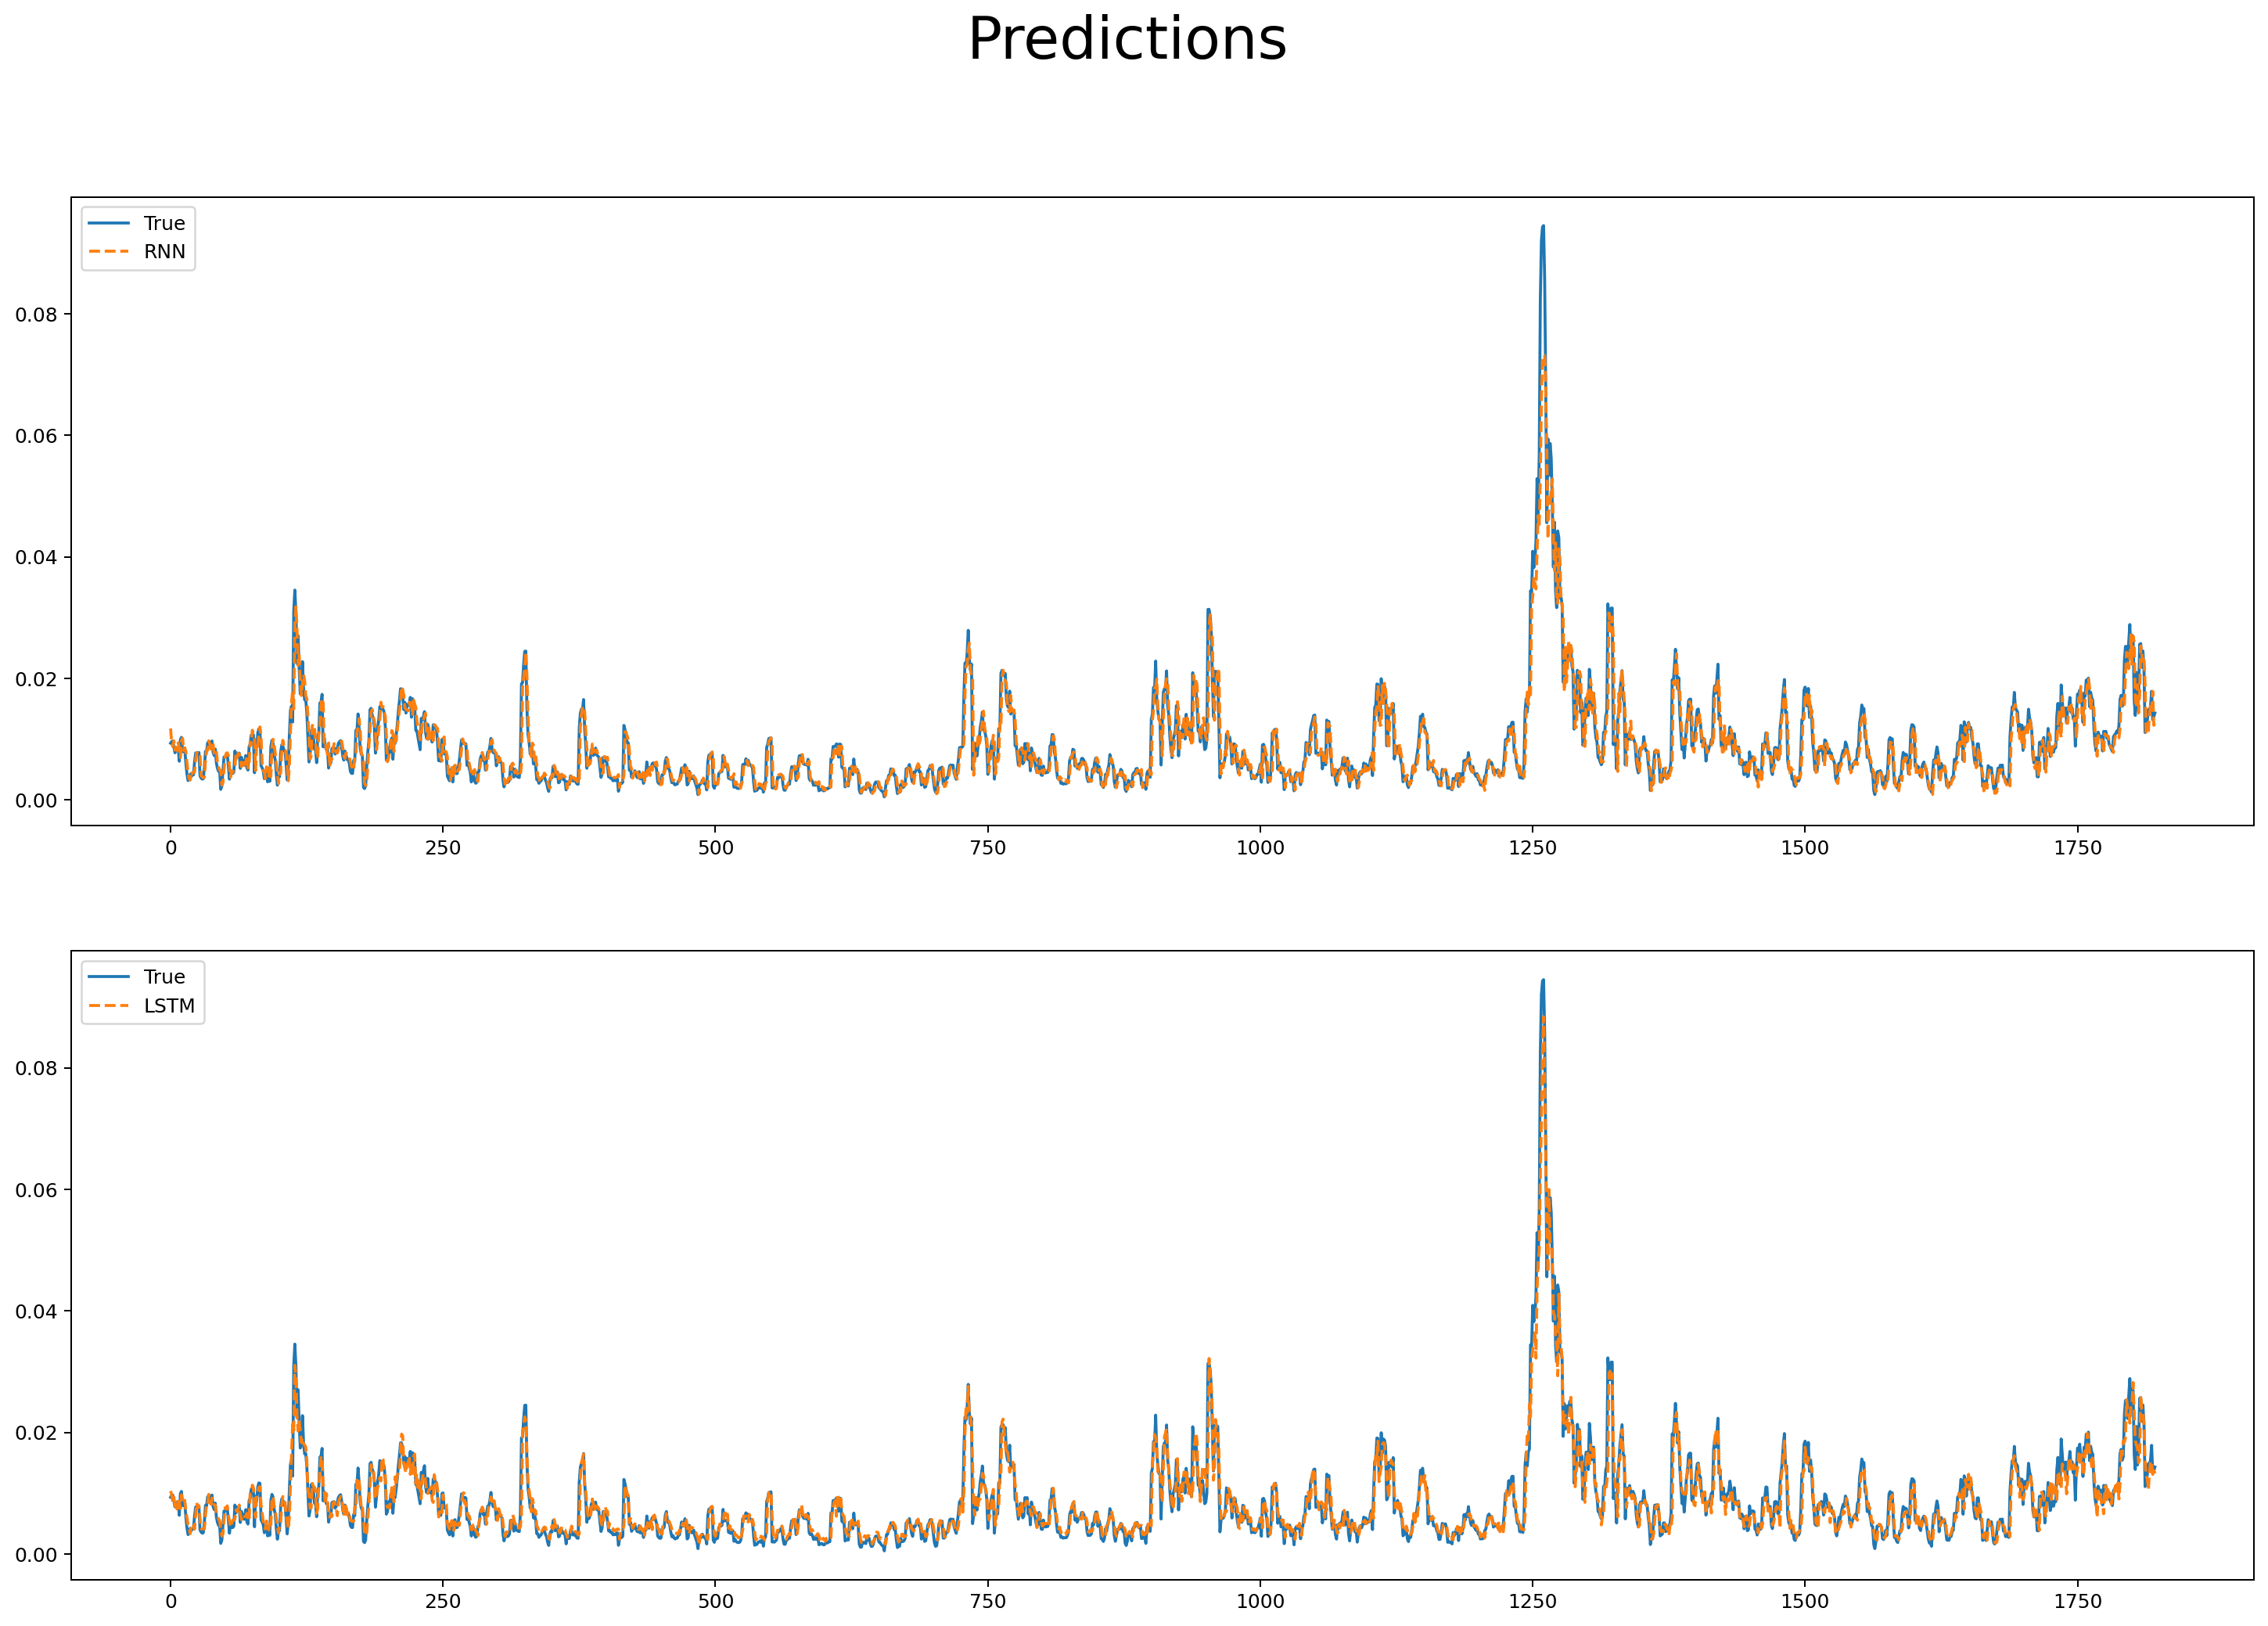

In [10]:
y_test_unscaled = y_test * volatility.max() + volatility.min()

fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=180)
fig.suptitle("Predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test_unscaled, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test_unscaled, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

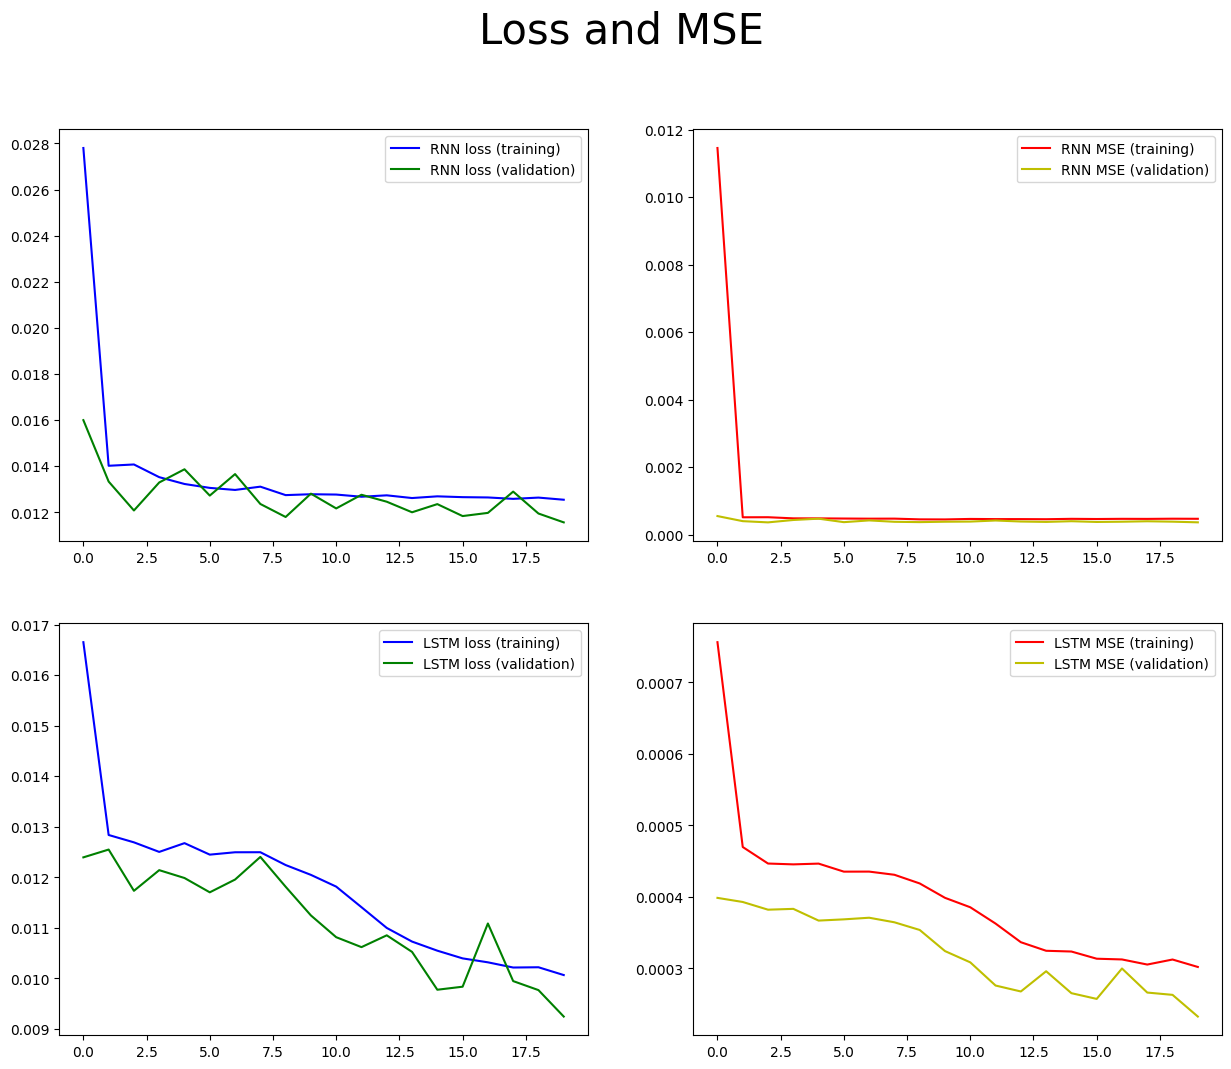

In [12]:
fig, ax = plt.subplots(len(metrics), 2, figsize=(15, 6 * len(metrics)), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

for m in range(len(metrics.keys())):
    model = list(models.keys())[m]

    ax[m, 0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
    ax[m, 0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
    ax[m, 0].legend(loc=0)

    ax[m, 1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
    ax[m, 1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
    ax[m, 1].legend(loc=0)